In [1]:
import pandas as pd
import os
import time
import keras_ocr
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [2]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\mfortier\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\mfortier\.keras-ocr\crnn_kurapan.h5


In [3]:
subdir_path = 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/'

In [4]:
img_fns = []
for file in os.listdir(subdir_path):
    img_fns.append(subdir_path + file)

In [5]:
#working 3
batch_i = 3
batch_f = 7
img_fns[batch_i:batch_f]

['L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0004.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0005.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0006.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0007.png']

In [6]:
start = time.time()

imgs_ocr = [
    keras_ocr.tools.read(img) for img in img_fns[batch_i:batch_f]
]

end = time.time()
t = end - start
print('Time to read all images in subdirectory: ' + str(round(t/60, 1)) + ' min')

Time to read all images in subdirectory: 0.0 min


In [7]:
start = time.time()
prediction_groups = pipeline.recognize(img_fns[batch_i:batch_f])
end = time.time()
t = end - start
print('Time to ocr process all images in subdirectory: ' + str(round(t/60, 1)) + ' min')

1/1 [==============================] - 3s 3s/step
Time to ocr process all images in subdirectory: 0.2 min


In [8]:
len(prediction_groups)

4

In [9]:
df_results = pd.DataFrame()
for i in range(0, len(prediction_groups)):
    df_ocr = pd.DataFrame()
    predicted_image = prediction_groups[i]
    if len(predicted_image) > 0:
        for text, box in predicted_image:
            row = pd.DataFrame({
                'number': text,
                'x': box[1][0],
                'y': box[1][1]
            }, index=[0])
            df_ocr = pd.concat([df_ocr, row])
        df_ocr = df_ocr.sort_values('x').reset_index(drop=True)
        print(df_ocr)
    if len(df_ocr) == 6:
        #The first number varies with ISIS
        row2 = pd.DataFrame({
            'station_number': df_ocr['number'].iloc[1],
            'year': df_ocr['number'].iloc[2],
            'day_of_year': df_ocr['number'].iloc[3],
            'hour': df_ocr['number'].iloc[4][0:2],
            'minute': df_ocr['number'].iloc[4][2:],
            'second': df_ocr['number'].iloc[5],
            'filename': img_fns[batch_i + i].replace(subdir_path, '')
        }, index=[0])
        df_results = pd.concat([df_results, row2])

  number           x           y
0     ts  557.085938  377.736328
1     ce  597.164062  377.736328
  number           x           y
0     do  541.269531  379.306641
1     ti  583.066406  376.171875
2     cs  623.191406  374.291016
3    ess  681.289062  378.261719
4  cctis  745.029297  375.126953
5     tt  785.781250  376.171875
  number           x           y
0     vo  523.505859  376.171875
1     ll  566.347656  375.126953
2     cs  605.009766  374.082031
3   tnes  664.570312  377.216797
4   ucao  727.265625  374.082031
5     cn  766.972656  375.126953
  number           x           y
0      c  504.697266  377.216797
1    lis  547.539062  375.126953
2     ce  586.201172  375.126953
3     lc  681.289062  375.126953
4      o  708.457031  378.261719


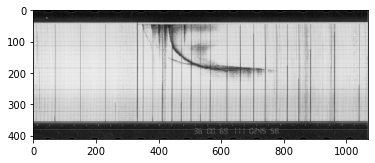

In [10]:
img_fn = subdir_path + 'Image0005.png'
img = mpimg.imread(img_fn)
plt.imshow(img)

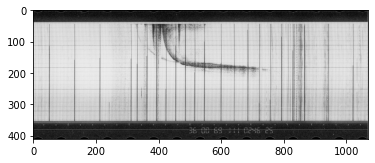

In [11]:
img_fn = subdir_path + 'Image0006.png'
img = mpimg.imread(img_fn)
plt.imshow(img)

In [12]:
df_results

,station_number,year,day_of_year,hour,minute,second,filename
0,ti,cs,ess,cc,tis,tt,Image0005.png
0,ll,cs,tnes,uc,ao,cn,Image0006.png


#  

Clearly the default recognizer is not adequate, as it can sometimes classify fuzzy numbers as letters.

We will need to 'fine-tune' the recognizer to only recognize numbers:

Ref: https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html <br>
Ref (better): https://keras-ocr.readthedocs.io/en/stable/examples/end_to_end_training.html <br>
Ref: https://github.com/faustomorales/keras-ocr/issues/54

In [13]:
import zipfile
import datetime
import string
import math
import os
import numpy as np

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

#assert tf.test.is_gpu_available(), 'No GPU is available.'

In [14]:
data_dir = 'L:/DATA/ISIS/keras_ocr/'
alphabet = string.digits + ''  #+ string.ascii_letters + '!?. ' #'0123456789'
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)

Looking for L:/DATA/ISIS/keras_ocr/fonts.zip
Unzipping fonts ZIP file.


Filtering fonts.: 100%|████████████████████████████████████████████████████████████| 2746/2746 [01:11<00:00, 38.23it/s]


In [57]:
isis_image = 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/'
backgrounds = os.listdir(isis_image)
backgrounds = [isis_image + image for image in backgrounds]

['L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0001.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0002.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0003.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0004.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0005.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0006.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0007.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0008.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0009.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0010.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/Image0011.png',
 'L:/DATA/ISIS/raw_upload_20230421/R0142078

In [58]:
text_generator = keras_ocr.data_generation.get_text_generator(alphabet=alphabet)
print('The first generated text is:', next(text_generator))

The first generated text is: 6000


In [59]:
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

In [60]:
background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

In [61]:
image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

image_generators

[<generator object get_image_generator at 0x00000238C6EDE7B0>,
 <generator object get_image_generator at 0x00000238C6EDE5F0>,
 <generator object get_image_generator at 0x00000238C6EDE890>]

In [62]:
# See what the first validation image looks like.
image, lines = next(image_generators[0])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

AxisError: axis 1 is out of bounds for array of dimension 1

In [32]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False

Looking for C:\Users\mfortier\.keras-ocr\craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\mfortier\.keras-ocr\crnn_kurapan_notop.h5


In [53]:
detector_batch_size = 1
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit(
    detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=1000,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size),
    batch_size=detector_batch_size
)

AxisError: axis 1 is out of bounds for array of dimension 1

In [24]:
background_splits

(['C:/users/rnaidoo/Documents/Projects_data/Alouette_I/keras_ocr/backgrounds_Alouette_I/65.jpg',
  'C:/users/rnaidoo/Documents/Projects_data/Alouette_I/keras_ocr/backgrounds_Alouette_I/18.jpg',
  'C:/users/rnaidoo/Documents/Projects_data/Alouette_I/keras_ocr/backgrounds_Alouette_I/65.jpg',
  'C:/users/rnaidoo/Documents/Projects_data/Alouette_I/keras_ocr/backgrounds_Alouette_I/65.jpg',
  'C:/users/rnaidoo/Documents/Projects_data/Alouette_I/keras_ocr/backgrounds_Alouette_I/47.jpg',
  'C:/users/rnaidoo/Documents/Projects_data/Alouette_I/keras_ocr/backgrounds_Alouette_I/18.jpg',
  'C:/users/rnaidoo/Documents/Projects_data/Alouette_I/keras_ocr/backgrounds_Alouette_I/18.jpg'],
 ['C:/users/rnaidoo/Documents/Projects_data/Alouette_I/keras_ocr/backgrounds_Alouette_I/47.jpg'],
 ['C:/users/rnaidoo/Documents/Projects_data/Alouette_I/keras_ocr/backgrounds_Alouette_I/47.jpg'])

In [25]:
image_generators

[<generator object get_image_generator at 0x0000021AFFBA7270>,
 <generator object get_image_generator at 0x0000021AFFBA7190>,
 <generator object get_image_generator at 0x0000021AFFBA70B0>]

In [26]:
image_generators[1]

<generator object get_image_generator at 0x0000021AFFBA7190>

In [28]:
next(image_generators[1], image_generators[1])

<generator object get_image_generator at 0x0000021AFFBA7190>

In [1]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False

NameError: name 'keras_ocr' is not defined

#  

In [ ]:
recognizer = keras_ocr.recognition.Recognizer(alphabet=alphabet, weights=None)#'kurapan')
recognizer.compile()

In [ ]:
#predicted = recognizer.recognize(subdir_path + '102.png')
#predicted

Use 'Born Digital' training set to re-train model with new alphabet:

In [ ]:
train_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='train',
    cache_dir='.'
)
test_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='test',
    cache_dir='.'
)
train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]
test_labels = [(filepath, box, word.lower()) for filepath, box, word in test_labels]

In [ ]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

In [ ]:
image, text = next(training_image_gen)
print('text:', text)
plt.imshow(image)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1000,
)